# Analiza i Przetwarzanie Obrazów - projekt

## Generowanie obrazów - stable diffusion

Instalacja odopwiednich pakietów Python'a

In [ ]:
pip install --upgrade diffusers transformers scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 114.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [ ]:
import torch
from diffusers import StableDiffusionPipeline
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import networkx as nx
import heapq
from google.colab.patches import cv2_imshow
from random import sample

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
#Generowanie obrazów

prompt = "A simple map of an urban area, roads are light color, road are wide, image is clean"
map_per_size = 3
sizes = [768, 1024, 1440]
generators = [torch.Generator("cuda").manual_seed(42), torch.Generator("cuda").manual_seed(42), torch.Generator("cuda").manual_seed(42)]

images = []

for i in range(len(sizes)):
  tmp_images = []
  for j in range(map_per_size):
    image = pipe(prompt, generator=generators[i], height=sizes[i], width=sizes[i], num_images_per_prompt=1).images[0]
    tmp_images.append(image)

  images.append(tmp_images)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#funkcja pomocnicza do wyświetlania obrazów wygenerowanych przez stable diffusion

def plot_images(image_list, gray=False):
  fig, axs = plt.subplots(1, len(image_list), figsize=(20, 20))

  for j, img in enumerate(image_list):
    if not gray:
      axs[j].imshow(img)
    else:
      axs[j].imshow(img, cmap="gray")

    axs[j].axis('off')

  plt.show()

In [ ]:
for image_list in images:
  plot_images(image_list)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#funkcja wykonująca preprocessing obrazu przez wysłaniem do algorytmu najkrotszej sciezki

def apply_threshold(image):
  image_np = np.array(image)
  image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


  #klasteryzacja
  Z = image_np.reshape((-1, 3))
  Z = np.float32(Z)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10, 1.0)

  K = 4
  _,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((image_np.shape))

  #progowanie

  gray_image = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)

  ret, thresh_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  kernel = np.ones((2, 2),np.uint8)
  thresh_image = cv2.dilate(thresh_image, kernel, iterations = 1)

  kernel = np.ones((2, 2),np.uint8)
  thresh_image = cv2.erode(thresh_image, kernel, iterations = 1)

  return thresh_image


Zobaczmy wyniki preprocessingu dla wygenerowanych obrazów

In [ ]:
thresh_images = []

for i in range(len(images)):
  tmp_thresh = []

  for j in range(len(images[i])):
    thresh_image = apply_threshold(images[i][j])
    tmp_thresh.append(thresh_image)

  thresh_images.append(tmp_thresh)

In [ ]:
for thresh_list in thresh_images:
  plot_images(thresh_list, gray=True)

Output hidden; open in https://colab.research.google.com to view.

# Część algorytmowa

In [ ]:
# Wczytanie mapy z drogami
def load_map(file_path):
    image = cv2.imread(file_path)
    return image

# Wizualizacja mapy z zaznaczonymi punktami
def plot_map_with_points(map_data, point1, point2):
    plt.imshow(map_data, cmap='gray')
    plt.plot(point1[1], point1[0], 'rx', markersize=10, label='Point 1')
    plt.plot(point2[1], point2[0], 'rx', markersize=10, label='Point 2')
    plt.legend()
    plt.show()

In [ ]:
# Wyznaczenie najkrótszej drogi między dwoma punktami
def make_graph(map_data):
    # Konwersja mapy na graf
    jasnosc =100
    graph = nx.Graph()
    height, width = map_data.shape[:2]
    print("Wysokosc: ",height, " Szerokosc: ",width)
    for row in range(height):
        for col in range(width):
            if map_data[row, col] > jasnosc:  # Odcinek drogi (jaśniejszy niż tło)
                graph.add_node((row, col))
                i = row;
                j=col;
                szerokosc=1;
                wysokosc=1;
                while( map_data[i,col]>jasnosc and i < height-1):
                  i = i+1
                  szerokosc =szerokosc+1

                i=row;

                while( map_data[i,col]> jasnosc and  i > 0):
                  i = i -1
                  szerokosc = szerokosc+1

                while( map_data[row,j]>jasnosc and j< width-1):
                  j= j + 1
                  wysokosc = wysokosc + 1

                j=col

                while( map_data[row,j]>jasnosc and j>0):
                  j= j -1
                  wysokosc = wysokosc + 1


                if row > 0 and map_data[row - 1, col] > jasnosc:
                    graph.add_edge((row, col), (row - 1, col), weight=1/wysokosc)
                if col > 0 and map_data[row, col - 1] >jasnosc:
                    graph.add_edge((row, col), (row, col - 1), weight=1/szerokosc)
                if row < height - 1 and map_data[row + 1, col] >jasnosc:
                    graph.add_edge((row, col), (row + 1, col), weight=1/wysokosc)
                if col < width - 1 and map_data[row, col + 1] >jasnosc:
                    graph.add_edge((row, col), (row, col + 1), weight=1/szerokosc)

                #chodzenie na ukos
                i=row
                j=col
                # kierunek \
                szer_k1=1

                while( map_data[i,j]>jasnosc and i < height -1 and j< width-1):
                  i = i+1
                  j = j+1
                  szer_k1 =szer_k1+1

                i=row
                j=col
                while( map_data[i,j]>jasnosc and i > 0 and j>0 ):
                  i = i-1
                  j = j-1
                  szer_k1 =szer_k1+1

                if row > 0 and col < width-1 and map_data[row - 1, col + 1] > jasnosc:
                    graph.add_edge((row, col), (row - 1, col + 1), weight=1/szer_k1)
                if col > 0 and row< height-1 and map_data[row + 1, col - 1] >jasnosc:
                    graph.add_edge((row, col), (row + 1, col - 1), weight=1/szer_k1)

                i=row
                j=col
                # kierunek /
                szer_k2=1

                while( map_data[i,j]>jasnosc and i > 0 and j< width-1):
                  i = i-1
                  j = j+1
                  szer_k2 =szer_k2+1

                i=row
                j=col
                while( map_data[i,j]>jasnosc and i < height-1 and j>0):
                  i = i+1
                  j = j-1
                  szer_k2 =szer_k2+1

                if row < height-1 and col< width-1 and map_data[row + 1, col+1] > jasnosc:
                    graph.add_edge((row, col), (row + 1, col + 1), weight=1/szer_k2)
                if col > 0 and row > 0 and map_data[row -1, col - 1] >jasnosc:
                    graph.add_edge((row, col), (row - 1, col - 1), weight=1/szer_k2)

    return graph


In [ ]:
#tworzenie graf z obrazu (na jednym grafie mozna szukac roznych sciezek)
def prepare_graph(image):
  image = np.asarray(image)
  return make_graph( apply_threshold(image))

# szukanie najkrotszej sciezki na obrazie image z ktorego przygotowano graf graph
# w przypadku nie podania punktow, sa one losowane z grafu
def find_shortest_path_on_image(image, graph, points=None):
  image = np.asarray(image)
  if points is None:
    points  = sample(list(graph.nodes()), 2)
  else:
    if not graph.has_node(points[0]) or not graph.has_node(points[1]):
      print("Przynajmniej jeden z punktów nie znajduje się w grafie.")
      plot_map_with_points(image, points[0], points[1])
      return

  point1 = points[0]
  point2 = points[1]
  print(f'Punkty: {point1}, {point2}')

  try:
    path = nx.shortest_path(graph, point1, point2, weight='weight')
  except nx.NetworkXNoPath:
     print("Brak ścieżki między punktami")
     plot_map_with_points(image, point1, point2)
     return

  if path is None:
    print("Nie znaleziono ścieżki.")
  else:
      map_image_rgb = image.copy()

      # Zaznaczenie ścieżki na mapie (-1/+1 by było lepiej widoczne)
      for node in path:
          x, y = node
          map_image_rgb[x-1:x+1, y-1:y+1] = [255, 0, 0]

      #zaznaczenie startu i konca
      map_image_rgb = cv2.circle(map_image_rgb, (path[0][1], path[0][0]), 2, (0, 0, 255), 5)
      map_image_rgb = cv2.circle(map_image_rgb, (path[-1][1], path[-1][0]), 2, (0, 0, 255), 5)

      cv2_imshow( map_image_rgb)

  return path


# Przykłady na wygenerowanych obrazach

Wysokosc:  768  Szerokosc:  768
Punkty: (631, 66), (538, 273)


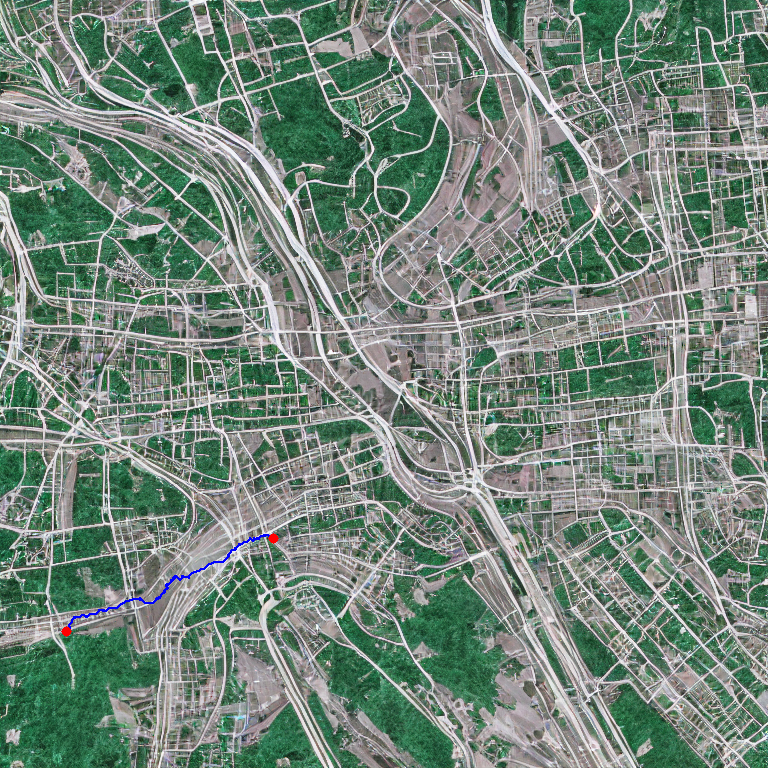

In [ ]:
#przyklad z mapka o rozdzielczosci 768 x 768

image_0 = images[0][1]
graph_0 = prepare_graph(image_0)
path_01 = find_shortest_path_on_image(image_0, graph_0)

Punkty: (501, 468), (595, 112)


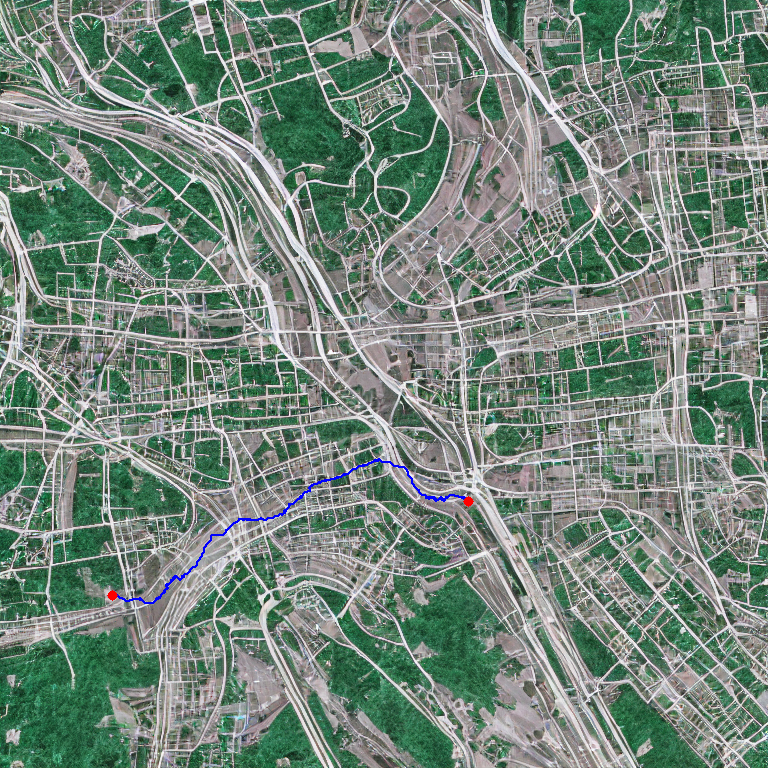

In [ ]:
#inne losowe punkty na tym samym obrazku - korzystamy z gotowego graph_0
path_02 = find_shortest_path_on_image(image_0, graph_0)

In [ ]:
#przyklad z mapka o rozdzielczosci 1024x1024

image_1 = images[1][0]
graph_1 = prepare_graph(image_1)
path_10 = find_shortest_path_on_image(image_1, graph_1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#przyklad z mapka o rozdzielczosci 1440 x 1440

image_2 = images[2][0]
graph_2 = prepare_graph(image_2)
path_20 = find_shortest_path_on_image(image_2, graph_2)

Output hidden; open in https://colab.research.google.com to view.

# Przykład z wczytanym obrazem

Wysokosc:  530  Szerokosc:  600
Punkty: (258, 297), (253, 492)


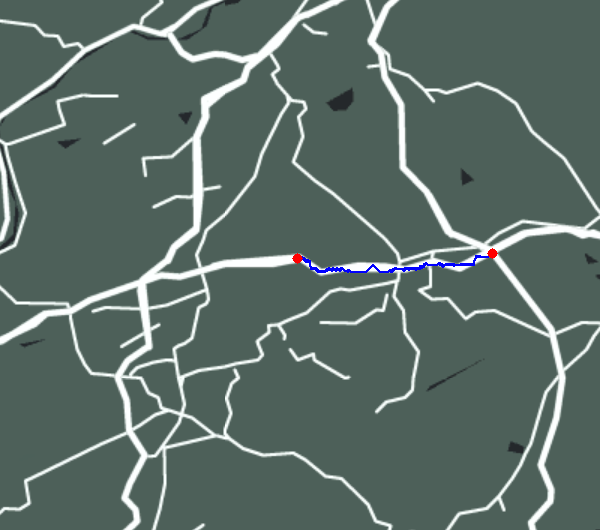

In [ ]:
image_r = load_map('mapka0.png')

graph_r = prepare_graph(image_r)
path_r = find_shortest_path_on_image(image_r, graph_r, points=[(258, 297), (253, 492)])

Punkty: (358, 297), (253, 492)
Brak ścieżki między punktami


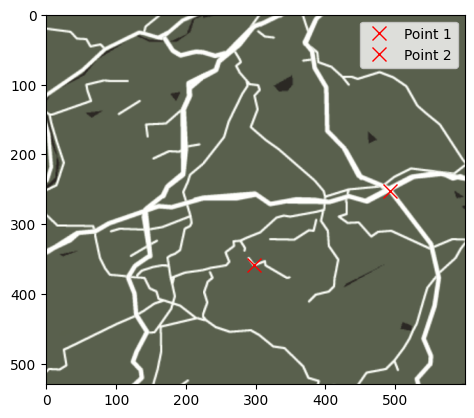

In [ ]:
#przyklad z punktami nie polaczonymi
path_r = find_shortest_path_on_image(image_r, graph_r, points=[(358, 297), (253, 492)])

Przynajmniej jeden z punktów nie znajdueje się w grafie.


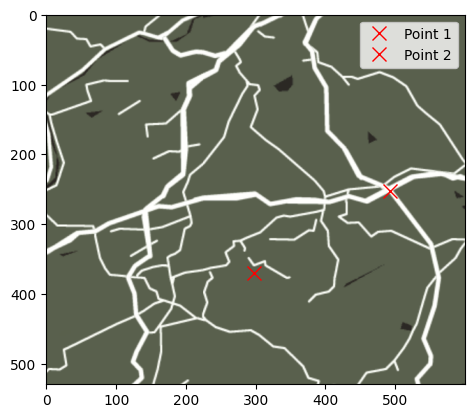

In [ ]:
#przyklad z punktem poza droga
path_r = find_shortest_path_on_image(image_r, graph_r, points=[(370, 297), (253, 492)])